
# Data Science Workshop for CBEAD @ HEC
## Author: René Eber

**Confidential - Do not duplicate or distribute without written permission from the author**




## Agenda

    1 Introduction to Business Case

    2 Pre-Processing / Data cleaning

    3 Exploratory Data Analysis (EDA) / Feature Engineering
        3.1 Target Variable
        3.2 Predictors
        3.3 Bivariate Analysis
        3.4 Multivariate Analysis

    4 Modeling & Evaluation

    5 Interpreatation

## 1. Introduction to Business Case


![alt text](https://firebasestorage.googleapis.com/v0/b/heccoding.appspot.com/o/urn-newsml-dpa-com-20090101-190731-99-278457-large-4-3-jpg.jpg?alt=media&token=fa866296-ec37-45a3-a19c-a513e61ea5dd)

&emsp;

**Background:** You are the management / chief data scientists of an emergency response company that is responsible for all UK road-crash emergencies. It is your responsibility to send an ambulance to the location of the crash (e.g. a car crash) and
  - transport the injured people to the closest hospital who need medical attention
  - provide medical emergency services to any people injured 

Generally there are two different types of ambulances, that vary in the spectrum of medical emergency services they can facilitate:

&emsp;

![alt text](https://firebasestorage.googleapis.com/v0/b/heccoding.appspot.com/o/Picture%201.png?alt=media&token=084ea103-ec82-44bf-a379-08a41a02439f)

&emsp;

The ambulance on the *left* has only the most basic medical equipment on board and is used for patients that are not critically injured.

The ambulance on the *right* can be understood as an extension of the hospital, as there are doctors on board as well as sophisticated medical equipment. Even advanced medical procedures such as a surgery can be performed, while on the way to the hospital.

&emsp;

**Objective:** You want to send the right type of ambulance as:
  - you only have a limited amount of ambulances of both types
  - the costs of sending an ambulance that is if for fatal accident severities along with the medical team is much more costly

&emsp;

**Problem:** You have to decide which ambulance to send, before you know about the severity of the accident. 

&emsp;

**Solution idea:** We want to predict the accident severity from data available at the time of the accident reporting. With these data we want to create a predictor for the severity of accident so we can make a smart decision on which type of ambulance to send once we receive the emergency call.

We will use the *publically accesible dataset of UK crash data* to create the predcition model.


### Where do we stand in the process?

![alt text](https://firebasestorage.googleapis.com/v0/b/heccoding.appspot.com/o/0*C_ibLD-RscbJzjMq.png?alt=media&token=2faaa4d8-d2ab-43c0-a490-15a670f24161)

## 2. Data Cleaning / Pre-Processing

First we import the "libraries" (e.g. pandas) that we are going to use in this workshop. These libraries contain all the functionalities that we are going to use (e.g. to calculate a mean, visualize data)

In [48]:
# Loading libraries
import os
import operator
import scipy.stats as stats
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
sns.set()


# connect to data storage server
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


&emsp;

Now we are ready to import the dataset 

In [49]:
# import data from a comma seperated files (csv) file  
crash_df = pd.read_csv('/content/drive/My Drive/Live Coding HEC/accidents_dataset_corrected.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



&emsp;

To get a first overview of the dataset let us look at the dimensions of the data as e.g. the number of crashes it entails, the number of columns



In [50]:
# dataframe.size returns size of dataframe/series which is equivalent to total number of elements. That is rows x columns.
size = crash_df.size 
  
# dataframe.shape returns tuple of shape (Rows, columns) of our dataset
shape = crash_df.shape 
  
# printing size and shape 
print("Size = {}\nShape ={}". 
format(size, shape)) 

Size = 4159424
Shape =(129982, 32)


&emsp;

Let's look a the first couple of data. **Question: What do we see?**

In [51]:
# display first 5 rows
crash_df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2017010001708,532920.0,196330.0,-0.080107,51.650061,1,1,2,3,05/08/2017,7,03:12,32,E09000010,3,105,6,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,E01001450
1,2017010009342,526790.0,181970.0,-0.173845,51.522425,1,3,2,1,01/01/2017,1,01:30,1,E09000033,3,5,6,30,3,4,6,0,0,0,4,1,2,0,0,1,1,E01004702
2,2017010009344,535200.0,181260.0,-0.052969,51.514096,1,3,3,1,01/01/2017,1,00:30,5,E09000030,3,13,6,30,3,4,5,0,0,0,4,1,1,0,0,1,1,E01004298
3,2017010009348,534340.0,193560.0,-0.060658,51.624832,1,3,2,1,01/01/2017,1,01:11,32,E09000010,3,1010,1,30,1,4,4,154,0,4,4,2,2,0,0,1,1,E01001429
4,2017010009350,533680.0,187820.0,-0.072372,51.573408,1,2,1,1,01/01/2017,1,01:42,4,E09000012,3,107,3,20,6,2,3,10,0,5,4,1,2,0,0,1,1,E01001808


&emsp;

Not all columns are relevant to use for our problem. To reduce complexity let's drop the one we can already deem as irrelevant. **Question: Which ones should we drop?**

In [0]:
# remove irrelevant columns
crash_df = crash_df.drop(columns=['Location_Easting_OSGR', 'Location_Northing_OSGR', "Local_Authority_(District)", "Local_Authority_(Highway)", "LSOA_of_Accident_Location", "Police_Force", "Accident_Index"])

&emsp;

If we map the longitude and latitude values of each accident onto an empty coordinate system. **Question: What do you expect to see?**

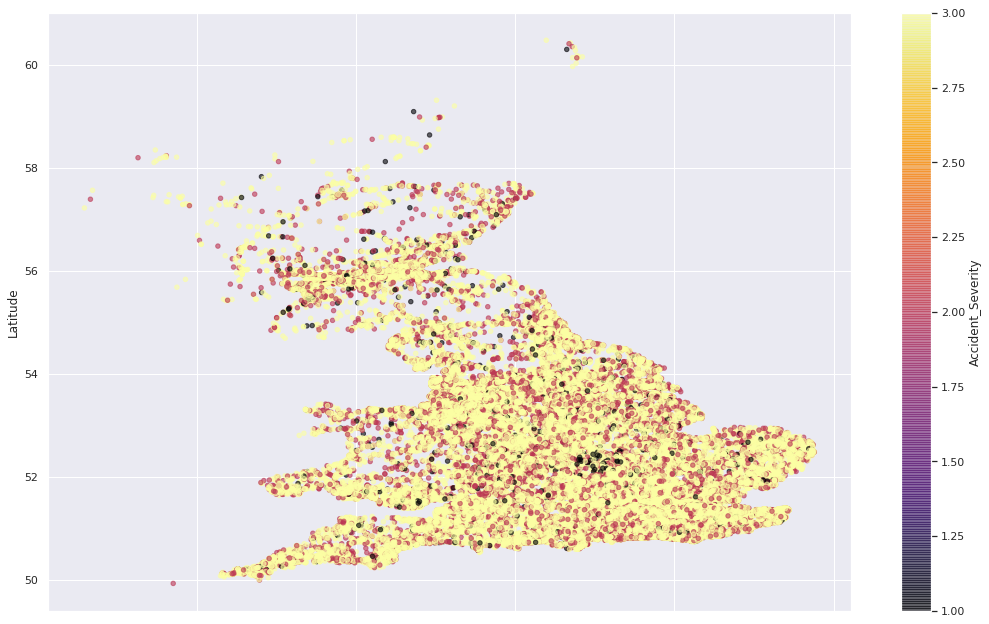

In [53]:
# lets mao the longitude and latitude 
fig = crash_df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.6,
                   figsize=(18,11),c="Accident_Severity", cmap=plt.get_cmap("inferno"), 
                   colorbar=True,)

&emsp;

The numerical values of some variables are impossible for us to interpet at this point (e.g. Junction_Detail). Let's go ahead and put some meaning to the numbers. **Question: How should we go about this?**

In this case we have a file where there is a description for each of the numbers. We simply match the number with the description.

In [0]:
# Read from file with number descriptions and replace number with description where possible
xls = pd.ExcelFile('/content/drive/My Drive/Live Coding HEC/Road-Accident-Safety-Data-Guide.xls')
for name in xls.sheet_names: 
  if name != "Introduction" and name != "Export Variables":
    names_df = pd.read_excel(xls, name)
    if name == "Ped Cross - Human":
      name = "Pedestrian_Crossing-Human_Control"
    if name == "Ped Cross - Physical":
      name = "Pedestrian_Crossing-Physical_Facilities"
    if name == "Weather":
      name = "Weather_Conditions"
    if name == "Road Surface":
      name = "Road_Surface_Conditions"
    if name == "Urban Rural":
      name = "Urban_or_Rural_Area"
    if name == "Police Officer Attend":
      name = "Did_Police_Officer_Attend_Scene_of_Accident"
    name = name.replace(" ", "_")
    if name in list(crash_df.columns):
      rename_dict = names_df.set_index('code').to_dict()['label']
      crash_df[name] = crash_df[name].replace(rename_dict)

&emsp;	

Now we should see meaningfull descriptions that we can interpret. Let's have a look again.

In [55]:
# Show first 5 rows of data
crash_df.head()

,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
0,-0.080107,51.650061,Fatal,2,3,05/08/2017,Saturday,03:12,A,105,Single carriageway,30,Not at junction or within 20 metres,Data missing or out of range,-1,0,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes
1,-0.173845,51.522425,Slight,2,1,01/01/2017,Sunday,01:30,A,5,Single carriageway,30,T or staggered junction,Give way or uncontrolled,Unclassified,0,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,Fine no high winds,Wet or damp,None,None,Urban,Yes
2,-0.052969,51.514096,Slight,3,1,01/01/2017,Sunday,00:30,A,13,Single carriageway,30,T or staggered junction,Give way or uncontrolled,C,0,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes
3,-0.060658,51.624832,Slight,2,1,01/01/2017,Sunday,01:11,A,1010,Roundabout,30,Roundabout,Give way or uncontrolled,B,154,None within 50 metres,"Pelican, puffin, toucan or similar non-junctio...",Darkness - lights lit,Raining no high winds,Wet or damp,None,None,Urban,Yes
4,-0.072372,51.573408,Serious,1,1,01/01/2017,Sunday,01:42,A,107,Dual carriageway,20,Crossroads,Auto traffic signal,A,10,None within 50 metres,Pedestrian phase at traffic signal junction,Darkness - lights lit,Fine no high winds,Wet or damp,None,None,Urban,Yes


&emsp;

Still we have values for some variables that we cannot interpret. **Question: Which one needs fixing?**

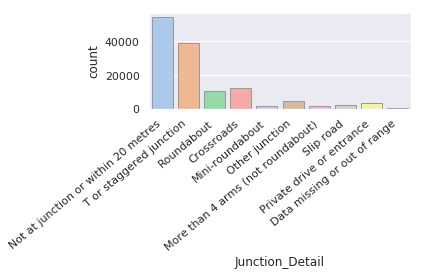

In [56]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
crash_details = "Junction_Detail" #@param ["Accident_Severity", "Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Special_Conditions_at_Site", "Carriageway_Hazards", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident"]
ax = sns.countplot(crash_df[crash_details], palette="pastel", edgecolor=".6")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

&emsp;

**Question: What does -1 refer to? Why does it occur so often?**

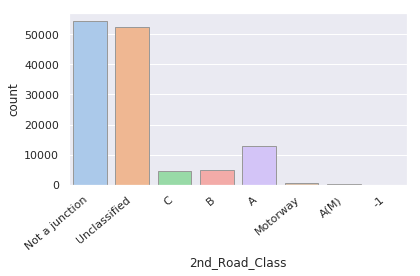

In [57]:
# Change -1 values in 2nd_Road_Type to "Not a junction" if the "Junction Detail" columns let's us see that there was no junction
crash_df.loc[(crash_df["Junction_Detail"] == 'Not at junction or within 20 metres') & (crash_df["2nd_Road_Class"] == -1), '2nd_Road_Class'] = 'Not a junction'  
crash_df.loc[(crash_df["Junction_Detail"] == 'Other junction') & (crash_df["2nd_Road_Class"] == -1), '2nd_Road_Class'] = 'Not a junction'  
crash_df.loc[(crash_df["Junction_Detail"] == 'Private drive or entrance') & (crash_df["2nd_Road_Class"] == -1), '2nd_Road_Class'] = 'Not a junction'  
crash_df.loc[(crash_df["Junction_Detail"] == 'T or staggered junction') & (crash_df["2nd_Road_Class"] == -1), '2nd_Road_Class'] = 'Not a junction'

# Plot the value distriburion once more for the "2nd_Road_Class" column
ax = sns.countplot(crash_df['2nd_Road_Class'], palette="pastel", edgecolor=".6")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

&emsp;

Now that we know the meaning for each variable and its value, let's turn towards the quality of the data. First we check for missing values that we need to taker care of.

In [58]:
# count all missing values per column
crash_df.isnull().sum()

Longitude                                      29
Latitude                                       29
Accident_Severity                               0
Number_of_Vehicles                              0
Number_of_Casualties                            0
Date                                            0
Day_of_Week                                     0
Time                                            3
1st_Road_Class                                  0
1st_Road_Number                                 0
Road_Type                                       0
Speed_limit                                     0
Junction_Detail                                 0
Junction_Control                                0
2nd_Road_Class                                  0
2nd_Road_Number                                 0
Pedestrian_Crossing-Human_Control               0
Pedestrian_Crossing-Physical_Facilities         0
Light_Conditions                                0
Weather_Conditions                              0


&emsp;

**Question: When do missing values occur in data and how could we handle them?**

In this case we simply remove any crashes that have missing data points as they are just not that many. More gerenale depending on the number missing values and their importance we have different mechanism to deal with them.

In [59]:
# Drop crashes with missing values
crash_df.dropna(inplace=True)

# count all missing values per column
crash_df.isnull().sum()

Longitude                                      0
Latitude                                       0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                               0
2nd_Road_Class                                 0
2nd_Road_Number                                0
Pedestrian_Crossing-Human_Control              0
Pedestrian_Crossing-Physical_Facilities        0
Light_Conditions                               0
Weather_Conditions                             0
Road_Surface_Conditi

&emsp;

Finally let's make sure, that the type of data matches the format we want to store it as. 

In [60]:
# display data type for each variable
crash_df.dtypes

Longitude                                      float64
Latitude                                       float64
Accident_Severity                               object
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                     object
Time                                            object
1st_Road_Class                                  object
1st_Road_Number                                  int64
Road_Type                                       object
Speed_limit                                      int64
Junction_Detail                                 object
Junction_Control                                object
2nd_Road_Class                                  object
2nd_Road_Number                                  int64
Pedestrian_Crossing-Human_Control               object
Pedestrian_Crossing-Physical_Facilities         object
Light_Cond

&emsp;

Great! For now we are done with the Pre-Processing and we can start with the Feature Engineering / Exploratory Data Analysis.

### Main points learned:

1. Reading data may come with format problems
2. Most of the time, the dataset needs explanation
3. There will be inconsistencies / errors in the data; they can be partly fixed with common sense
4. There will be no perfect dataset, unless it comes from a textbook
5. Be aware when leading Data Scientists, that machine learning requires a lot of data Data Cleanining / Pre-Processing, which can be up to 90% of the total time needed for the project

## 3. Feature engineering / Exploratory Data Analysis (EDA)


Feature Engineering / EDA is an approach to 
- analyzing datasets to summarize their main characteristics 
- using domain knowledge of the data to create features that make machine learning algorithms work

&emsp;

"*Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.*"

— Andrew Ng, Machine Learning and AI via Brain simulations

### 3.1 Target Variable

Let us start by looking at our target variable - the severity of the crash. Based on the severity we would send a different type of ambulance.

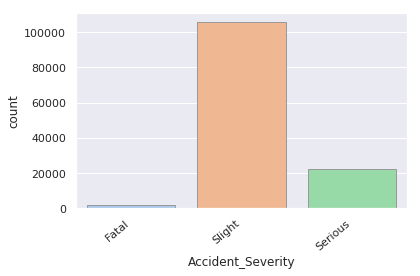

In [61]:
# Display count of crashed for each severity
ax = sns.countplot(crash_df['Accident_Severity'], palette="pastel", edgecolor=".6")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### 3.2 Predictors

The other columns, that we will use to predict the severity are called the input variables, features or predictors. 

Depending on the type of variable - if you recall there are categorical and continous variables -  we can do different type of analysis methods (e.g. there is no average for categorical variables)

#### 3.2.1 Categorical variables

As with the target variable, let us check the count of each category for each variable to see if we can already see something interesting. **Question: Is there anything of interest?**

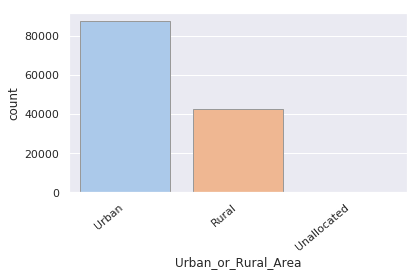

In [62]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
crash_details = "Urban_or_Rural_Area" #@param ["Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Special_Conditions_at_Site", "Carriageway_Hazards", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident"]
ax = sns.countplot(crash_df[crash_details], palette="pastel", edgecolor=".6")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

&emsp;

#### 3.2.2 Continous variables

For continous variables we can look at summary statistics. **Question: Does this statistic make sense for all our numerical variables?**

In [63]:
# Calculate mean, count, std etc. for all continous variables
continous_variables = crash_df[["Number_of_Vehicles", "Number_of_Casualties", "Latitude", "Longitude", "Speed_limit",  "1st_Road_Number" , "2nd_Road_Number"]]
summary = continous_variables.describe()
summary

,Number_of_Vehicles,Number_of_Casualties,Latitude,Longitude,Speed_limit,1st_Road_Number,2nd_Road_Number
count,129950.000000,129950.000000,129950.000000,129950.000000,129950.000000,129950.000000,129950.000000
mean,1.838169,1.315514,52.439382,-1.268373,37.257484,852.030019,301.224625
std,0.722481,0.765509,1.382513,1.395883,13.976424,1692.951525,1152.502000
min,1.000000,1.000000,49.929558,-7.409550,20.000000,0.000000,-1.000000
25%,1.000000,1.000000,51.470400,-2.190701,30.000000,0.000000,0.000000
50%,2.000000,1.000000,51.900635,-1.149749,30.000000,43.000000,0.000000
75%,2.000000,1.000000,53.393001,-0.141683,40.000000,587.000000,0.000000
max,23.000000,42.000000,60.480924,1.759641,70.000000,9786.000000,9704.000000


&emsp;

As with the categorical variables lets look at the distributions of values for each predictor. As we are dealing with continous variables we could have indefinite many different values in the dataset. Therefore we are "boxing them", by aggreagting over value ranges (e.g. aggreagting over 1-20 instead of looking at each value individually).

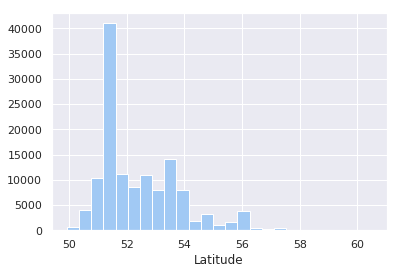

In [64]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
crash_details = "Latitude" #@param ["Number_of_Vehicles", "Number_of_Casualties", "Latitude", "Longitude", "Speed_limit",  "1st_Road_Number" , "2nd_Road_Number"]

sns.set(palette="pastel")
sns.distplot(crash_df[crash_details], norm_hist=False, kde=False, bins=25, hist_kws={"alpha": 1})
plt.show()

&emsp;

### 3.3 Bivariate Analysis

Diving deeper, we now compare different predictor (e.g. speed) to the target variable (the accident severity in our case) to see if we intuitively think that there is e.g. a correlation. **Question: Why do we bother for correlation and for which variable do we presume one?**

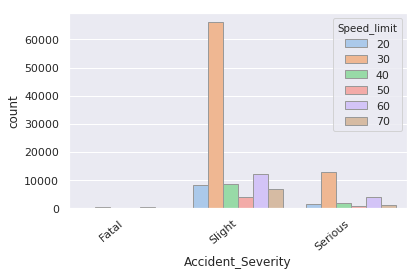

In [65]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

crash_details = "Speed_limit" #@param ["Speed_limit", "Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Special_Conditions_at_Site", "Carriageway_Hazards", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident"]
#filtered_df = crash_df.loc[crash_df[crash_details].isin(ranges)]
ax = sns.countplot(x="Accident_Severity", hue=crash_details, data=crash_df, palette="pastel", edgecolor=".6")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

&emsp;

Let's have a closer look at Speed limits. **What is your hypothesis?**

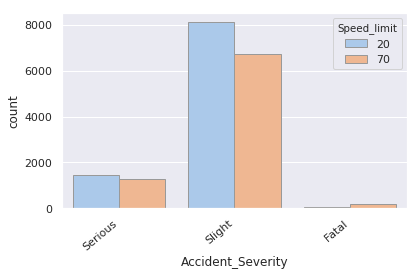

In [66]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

crash_details = "Speed_limit" #@param ["Speed_limit"]
speed_1 = "20" #@param ["20", "30", "40", "50", "60", "70"]
speed_2 = "70" #@param ["20", "30", "40", "50", "60", "70"]
speed = [speed_1, speed_2]

filtered_df = crash_df.loc[crash_df[crash_details].isin(speed)]
ax = sns.countplot(x="Accident_Severity", hue=crash_details, data=filtered_df, palette="pastel", edgecolor=".6")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


&emsp;

### 3.4 Multivariate Analysis

Multivariate Analysis helps to illustrate the bayesian posterior probability. **Question: What further variable should we consider with given speed, to form a better hypothesis?**

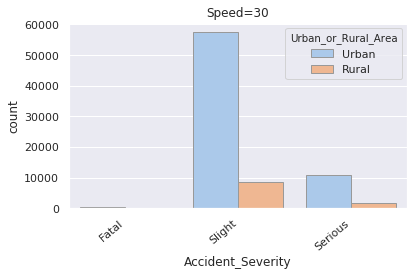

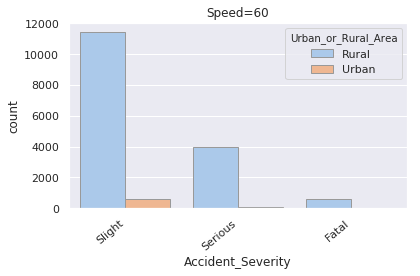

In [67]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
crash_details = "Speed_limit" #@param ["Speed_limit"]
speed_1 = "30" #@param ["20", "30", "40", "50", "60", "70"]
speed_2 = "60" #@param ["20", "30", "40", "50", "60", "70"]
speed = [speed_1, speed_2]
crash_details_2 = "Urban_or_Rural_Area" #@param ["Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Special_Conditions_at_Site", "Carriageway_Hazards", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident"]

for item in speed:
  filtered_df = crash_df.loc[crash_df[crash_details] == int(item)]
  ax = sns.countplot(x="Accident_Severity", hue=crash_details_2, data=filtered_df, palette="pastel", edgecolor=".6")
  ax.set_title("Speed="+item)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.show()

&emsp;

Let's look at it the other way round. Given the other variable, what is the speed limit counts per accident severity. **Question: Which variable combinations are good features?**

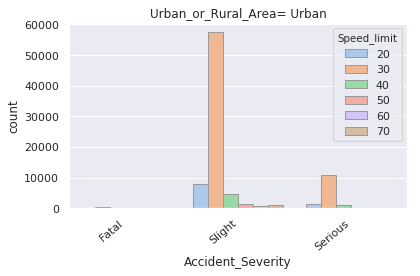

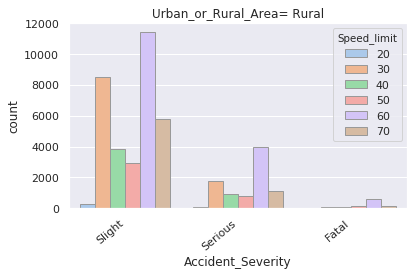

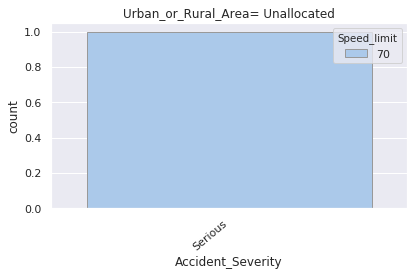

In [69]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
crash_details = "Urban_or_Rural_Area" #@param ["Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Special_Conditions_at_Site", "Carriageway_Hazards", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident"]
distinct_values = crash_df[crash_details].unique().tolist()
crash_details_2 = "Speed_limit" #@param ["Speed_limit"]

for item in distinct_values:
  filtered_df = crash_df.loc[crash_df[crash_details] == item]
  ax = sns.countplot(x="Accident_Severity", hue=crash_details_2, data=filtered_df, palette="pastel", edgecolor=".6")
  ax.set_title(crash_details+ "= " +item)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.show()


### Main points learned:
1. During the analysis, additional questions and problems always come up
2. Analysing the data without a guiding business question takes exponential amount of time
3. Bivariate analysis gives indications on relationsships, but no guarantee that they exist in a more complex model

## 4 Modeling

### 4.1 Encoding of variables

In [0]:
# remove some features
crash_df = crash_df.drop(columns=["Latitude",	"Longitude", "1st_Road_Number",	"2nd_Road_Number", "Date",	"Time",	"Special_Conditions_at_Site", "Carriageway_Hazards"])

#OneHotEncoded: "Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Special_Conditions_at_Site", "Carriageway_Hazards", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident"
crash_df = pd.get_dummies(crash_df, prefix=["Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident", "Weather_Conditions"], columns=["Day_of_Week","1st_Road_Class", "2nd_Road_Class","Road_Type", "Junction_Detail", "Junction_Control", "Light_Conditions", "Road_Surface_Conditions", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities", "Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident", "Weather_Conditions"])

#Categorize Strings: Accident_Severity
le = LabelEncoder()
crash_df['Accident_Severity'] = le.fit_transform(crash_df['Accident_Severity'].tolist())

# Normalize nunerical values - squeeze them between range 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(crash_df[["Speed_limit", "Number_of_Vehicles", "Number_of_Casualties"]])
crash_df[["Speed_limit", "Number_of_Vehicles", "Number_of_Casualties"]] = scaler.transform(crash_df[["Speed_limit", "Number_of_Vehicles", "Number_of_Casualties"]])

### 4.2 Train Test Split

In [0]:
y = crash_df["Accident_Severity"]
X = crash_df.drop(columns=['Accident_Severity'])

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

### 4.3 Models

#### 4.3.1 Neural Networks

#### 4.3.2 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support

# Number of trees in random forest
n_estimators = [2000]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#rf = RandomForestClassifier()
rf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 2, verbose=2, random_state=42, n_jobs = -1)

trained_rfc = rf.fit(X_train, y_train)
predictions = trained_rfc.predict(X_test)
 
# Train and Test Accuracy
print("Train Accuracy :: ", accuracy_score(y_train, trained_rfc.predict(X_train)))
print("Test Accuracy  :: ", accuracy_score(y_test, predictions))
print("Test Precision / Recall / F-Score :: ", precision_recall_fscore_support(y_test, predictions, average='weighted'))
#print(" Confusion matrix ", confusion_matrix(y_test, predictions))


In [0]:
print(" Confusion matrix ", confusion_matrix(y_test, predictions))

### 4.4 Model Scoring

## 5 Model Evaluation

## 6 Model Interpretability

In [0]:
import matplotlib.pyplot as plt
search.best_estimator_.plot_importance(search.best_estimator_)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
search.best_estimator_.to_graphviz(search.best_estimator_, num_trees=search.best_estimator_.best_iteration)